<a href="https://colab.research.google.com/github/vishnuvardhan833199/ML-Projects/blob/main/Email_sorting_agent_using_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Email Sorting: A LangGraph Example

In this notebook, **we're going to build a complete email processing workflow using LangGraph**.

## What You'll Learn

In this notebook, you'll learn how to:
1. Set up a LangGraph workflow
2. Define state and nodes for email processing
3. Create conditional branching in a graph
4. Connect an LLM for classification and content generation
5. Visualize the workflow graph
6. Execute the workflow with example data

In [ ]:
# Install the required packages
%pip install -q langgraph langchain_openai langchain_huggingface

## Setting Up Our Environment

First, let's import all the necessary libraries. LangGraph provides the graph structure, while LangChain offers convenient interfaces for working with LLMs.

In [ ]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = ""  # Replace with your actual API key

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

## Step 1: Define Our State

In LangGraph, **State** is the central concept. It represents all the information that flows through our workflow.

For Alfred's email processing system, we need to track:
- The email being processed
- Whether it's spam or not
- The draft response (for legitimate emails)
- Conversation history with the LLM

In [ ]:
class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    email_draft: Optional[str]
    messages: List[Dict[str, Any]]

## Step 2: Define Our Nodes

In [ ]:
def read_email(state: EmailState):
    email = state["email"]
    print(f"An AI Agent is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}


def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
As a professional email reader, analyze this email and determine if it is spam or legitimate and should be brought to Dr. Raj's attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only return the answer
Answer :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.content}
        ]
    else:
        new_messages = state.get("messages", [])

    return {
        "is_spam": is_spam,
        "messages": new_messages
    }


def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}


def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f"""
As an AI Agent, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Dr. Raj can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    return {
        "email_draft": response.content,
        "messages": new_messages
    }


def notify_mr_wayne(state: EmailState):
    email = state["email"]

    print("\n" + "=" * 50)
    print(f"Hello, I am your AI Agent. You have received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")

    return {}


# Define routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"


# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)  # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email)  # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam)  #same logic
email_graph.add_node("drafting_response", drafting_response)  #same logic
email_graph.add_node("notify_mr_wayne", notify_mr_wayne)  # same logic


## Step 3: Define Our Routing Logic

In [ ]:
# Add edges

email_graph.add_edge(START, "read_email")  # After starting we go to the "read_email" node

email_graph.add_edge("read_email", "classify_email")  # after_reading we classify

# Add conditional edges
email_graph.add_conditional_edges(
    "classify_email",  # after classify, we run the "route_email" function"
    route_email,
    {
        "spam": "handle_spam",  # if it return "Spam", we go the "handle_span" node
        "legitimate": "drafting_response"  # and if it's legitimate, we go to the "drafting response" node
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END)  # after handling spam we always end
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END)  # after notifyinf Me wayne, we can end  too


## Step 4: Create the StateGraph and Define Edges

In [ ]:
# Compile the graph
compiled_graph = email_graph.compile()

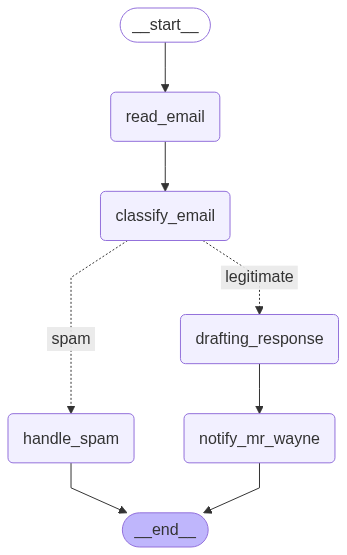

In [ ]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [ ]:
 # Example emails for testing
legitimate_email = {
    "sender": "Cognizant AI",
    "subject": "Potential partnership ! ",
    "body": "We would like to explore a potential partnership/collaboration with Vizuara. Do let us know a good time to reach you!"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
An AI Agent is processing an email from Cognizant AI with subject: Potential partnership ! 
ham

Hello, I am your AI Agent. You have received an email from Cognizant AI.
Subject: Potential partnership ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Potential Partnership

Dear [Name],

Thank you for reaching out to us at Vizuara. We are excited about the possibility of exploring a partnership with Cognizant AI. Dr. Raj will review your proposal and we will get back to you shortly to discuss potential collaboration opportunities.

In the meantime, please let us know your availability for a meeting, and we will do our best to accommodate.

Looking forward to the possibility of working together.

Best regards,

[Your Name]  
[Your Position]  
Vizuara  


Processing spam email...
An AI Agent is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marke

## Step 5: Inspecting Our Mail Sorting Agent with Langfuse 📡

As Alfred fine-tunes the Main Sorting Agent, he's growing weary of debugging its runs. Agents, by nature, are unpredictable and difficult to inspect. But since he aims to build the ultimate Spam Detection Agent and deploy it in production, he needs robust traceability for future monitoring and analysis.

To do this, Alfred can use an observability tool such as [Langfuse](https://langfuse.com/) to trace and monitor the inner steps of the agent.

First, we need to install the necessary dependencies:

In [ ]:
!pip install langfuse[langchain]


Next, we set the Langfuse API keys and host address as environment variables. You can get your Langfuse credentials by signing up for [Langfuse Cloud](https://cloud.langfuse.com) or [self-hosting Langfuse](https://langfuse.com/self-hosting).

In [ ]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = ""
os.environ["LANGFUSE_SECRET_KEY"] = ""
#os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"  # 🇪🇺 EU region
os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

Now, we configure the [Langfuse `callback_handler`](https://langfuse.com/docs/integrations/langchain/tracing#add-langfuse-to-your-langchain-application).

In [ ]:
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

We then add `config={"callbacks": [langfuse_handler]}` to the invocation of the agents and run them again.

In [ ]:
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


Processing legitimate email...
An AI Agent is processing an email from Cognizant AI with subject: Potential partnership ! 
ham

Hello, I am your AI Agent. You have received an email from Cognizant AI.
Subject: Potential partnership ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Potential Partnership

Dear [Recipient's Name],

Thank you for reaching out to us at Vizuara. We are excited about the possibility of collaborating with Cognizant AI and exploring potential partnership opportunities.

Dr. Raj would be pleased to discuss this further. Could you please suggest a few convenient times for a call or meeting? We will do our best to accommodate your schedule.

Looking forward to your response.

Best regards,

[Your Name]  
[Your Position]  
Vizuara


Processing spam email...
An AI Agent is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marked the email as spam.
The email

Alfred is now connected 🔌! The runs from LangGraph are being logged in Langfuse, giving him full visibility into the agent's behavior. With this setup, he's ready to revisit previous runs and refine his Mail Sorting Agent even further.

![Example trace in Langfuse](https://langfuse.com/images/cookbook/huggingface-agent-course/langgraph-trace-legit.png)

_[Public link to the trace with the legit email](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/f5d6d72e-20af-4357-b232-af44c3728a7b?timestamp=2025-03-17T10%3A13%3A28.413Z&observation=6997ba69-043f-4f77-9445-700a033afba1)_

![Example trace in Langfuse](https://langfuse.com/images/cookbook/huggingface-agent-course/langgraph-trace-spam.png)

_[Public link to the trace with the spam email](https://langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/6e498053-fee4-41fd-b1ab-d534aca15f82?timestamp=2025-03-17T10%3A13%3A30.884Z&observation=84770fc8-4276-4720-914f-bf52738d44ba)_
